In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from os import chdir
import numpy as np
import pickle
import scipy.stats as stats
import os


In [12]:
def clipAndNormalize(features,saveScalerPath = None):
    #clip the features to the range of the training data
    features.drop(['key','time_signature'], axis=1, inplace=True)
    #clip outliers to 1st and 99th percentile
    features['danceability'] = features['danceability'].clip(lower=features['danceability'].quantile(0.01), upper=features['danceability'].quantile(0.99))
    features['energy'] = features['energy'].clip(lower=features['energy'].quantile(0.01), upper=features['energy'].quantile(0.99))
    features['loudness'] = features['loudness'].clip(lower=features['loudness'].quantile(0.01), upper=features['loudness'].quantile(0.99))
    features['speechiness'] = features['speechiness'].clip(lower=features['speechiness'].quantile(0.01), upper=features['speechiness'].quantile(0.99))
    features['acousticness'] = features['acousticness'].clip(lower=features['acousticness'].quantile(0.01), upper=features['acousticness'].quantile(0.99))
    features['instrumentalness'] = features['instrumentalness'].clip(lower=features['instrumentalness'].quantile(0.01), upper=features['instrumentalness'].quantile(0.99))
    features['liveness'] = features['liveness'].clip(lower=features['liveness'].quantile(0.01), upper=features['liveness'].quantile(0.99))
    features['valence'] = features['valence'].clip(lower=features['valence'].quantile(0.01), upper=features['valence'].quantile(0.99))
    features['tempo'] = features['tempo'].clip(lower=features['tempo'].quantile(0.01), upper=features['tempo'].quantile(0.99))
    features['duration_ms'] = features['duration_ms'].clip(lower=features['duration_ms'].quantile(0.01), upper=features['duration_ms'].quantile(0.99))
    #features['time_signature'] = features['time_signature'].clip(lower=features['time_signature'].quantile(0.01), upper=features['time_signature'].quantile(0.99))

    columns_to_log=['liveness', 'instrumentalness', 'acousticness', 'speechiness','loudness','energy']

    for i in columns_to_log:
        if i == 'loudness':
            features[i] = features[i] + 60
        features[i] = np.log(features[i]+1)

    
    #normalize the data
    scaler = StandardScaler()

    #if id is a column, drop it
    if 'id' in features.columns:
        #fit on all columns except the track id
        rawfeatures = features.drop(['id'], axis=1)
    else:
        rawfeatures = features
    preprocessedFeatures = scaler.fit_transform(rawfeatures)

    preprocessedFeaturesDF = pd.DataFrame(preprocessedFeatures, columns=rawfeatures.columns)

    #apply z-score normalization
    for i in columns_to_log:
        preprocessedFeaturesDF[i] = stats.zscore(preprocessedFeaturesDF[i])
        preprocessedFeaturesDF.clip(lower=-2.7, upper=2.7, inplace=True)

    
    if saveScalerPath is not None:
        pickle.dump(scaler, open(saveScalerPath, 'wb'))
    return preprocessedFeaturesDF, preprocessedFeatures

In [3]:
def makeCategorical(df):
    mood_order=['sad','angry','energetic','excited','happy','content','calm','depressed']
    mood_codes, mood_categories = pd.factorize(mood_order)
    
    # Create a categorical object with the desired order
    cat = pd.Categorical(df['mood'], categories=mood_order, ordered=True)

    # Get the integer codes of the categories
    codes = cat.codes

    # Add the codes as a new column to the dataframe
    df['mood_code'] = codes
    return df



In [4]:
chdir('C:/Users/mlar5/OneDrive/Desktop/Code Folder/Python Projects/IRL projects/Aspire - Affective Computing Project/Playlists Data/Audio Features/emotion joint data')

In [5]:
emotionsDF = pd.read_csv('Merged Emotions Data4.csv')

In [6]:
emotionsDF = makeCategorical(emotionsDF)

In [7]:
emotionsDF['mood_code'].value_counts()

7    3781
6    1218
0    1020
5     773
1     694
3     678
2     631
4     519
Name: mood_code, dtype: int64

In [8]:
# create a new df with only up to 500 songs per mood_code
# this is to balance the data

balancedDF = pd.DataFrame(columns=emotionsDF.columns)

for i in emotionsDF['mood_code'].unique():
    df = emotionsDF[emotionsDF['mood_code']==i]
    #if the value count of the mood_code is larger than 500, sample 500
    if df['mood_code'].value_counts()[i] > 600:
        df = df.sample(n=600, random_state=42)
    #if the value count of the mood_code is less than 500, sample the value count
    else:
        df = df.sample(n=df['mood_code'].value_counts()[i])
    balancedDF = pd.concat([balancedDF, df])

balancedDF['mood_code'].value_counts()

1    600
6    600
5    600
7    600
2    600
3    600
0    600
4    519
Name: mood_code, dtype: int64

In [9]:
balancedDF.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,duration_ms,time_signature,song,mood,genre,mood_code
381,0.848,0.520,5,-10.663,0,0.5010,0.002250,0.000799,0.679,0.304,149.996,spotify:track:2XSrt1dcuOXPgl3B4bxmBz,203897,4,Carrollton,angry,rap,1
666,0.713,0.698,10,-7.435,0,0.1680,0.180000,0.000001,0.304,0.480,124.973,spotify:track:1SSv8SA2OHfOUwLgb8yOum,180062,4,Cheat Cxdes,angry,rap,1
257,0.757,0.423,1,-2.311,1,0.0527,0.000004,0.897000,0.118,0.125,130.058,spotify:track:0A8Mrg7ButLr17K3A0R61D,133308,4,TOTALITARIANISM,angry,EDM,1
338,0.516,0.515,1,-13.005,1,0.2790,0.033600,0.000002,0.119,0.396,95.971,spotify:track:583TaS41X2JJGKoGXnTY3l,107159,4,KILLTHEPHARAOH,angry,rap,1
319,0.618,0.836,6,-4.750,0,0.0813,0.002400,0.000000,0.363,0.397,175.060,spotify:track:7CMy59461Q3pgsPZ4Cj8CP,89143,4,EASE,angry,rap,1


In [10]:
rawfeatures = balancedDF.drop(['uri', 'song','mood','genre','mood_code'], axis=1)

In [13]:
rawfeaturesDF, rawfeatures = clipAndNormalize(rawfeatures,saveScalerPath="C:/Users/mlar5/OneDrive/Desktop/Code Folder/198 Senior Design/Models/Spotipy v2/scaler4.pkl" )

In [14]:
rawfeaturesDF.head()

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,1.488028,-0.324204,-0.664186,-1.272304,2.700000,-0.952933,-0.493081,2.700000,-0.541971,0.926476,0.264184
1,0.553962,0.367703,0.061950,-1.272304,0.661370,-0.244509,-0.496604,1.016053,0.209154,0.062095,-0.200122
2,0.858399,-0.736215,1.129228,0.785976,-0.530739,-0.962075,2.332466,-0.475501,-1.305900,0.237749,-1.110890
3,-0.809082,-0.344790,-1.220784,0.785976,1.702663,-0.819289,-0.496603,-0.466836,-0.149338,-0.939734,-1.620273
4,-0.103343,0.855909,0.633346,-1.272304,-0.223283,-0.952284,-0.496610,1.444942,-0.145070,1.792274,-1.971225


In [15]:
y = balancedDF['mood_code']

In [16]:
#set it to categorical
y = y.astype('category')

In [17]:
X_train_standard, X_test_standard, y_train_standard, y_test_standard = train_test_split(rawfeatures, y, test_size=0.2, random_state=42, stratify=y)


In [18]:
def offByOne(y_test_standard, y_pred,digits=3):
    #compare y_test_standard with y_pred_list. If y_pred_list is +-1 from y_test_standard, then it change it to be the same as y_test_standard
    y_test_standard_list=list(y_test_standard)
    y_pred_list = list(y_pred)
    for id in range(len(y_test_standard_list)):
        if y_test_standard_list[id] != 0 and y_test_standard_list[id] != 7:
            if y_pred_list[id] == y_test_standard_list[id] - 1 or y_pred_list[id] == y_test_standard_list[id] + 1:
                y_pred_list[id] = y_test_standard_list[id]
        elif y_test_standard_list[id] == 0:
            if y_pred_list[id] ==  1 or y_pred_list[id] == 7:
                y_pred_list[id] = y_test_standard_list[id]
        elif y_test_standard_list[id] == 7:
            if y_pred_list[id] ==  0 or y_pred_list[id] == 6:
                y_pred_list[id] = y_test_standard_list[id]
    print(classification_report(y_test_standard_list, y_pred_list,digits = digits))
    return

## skip when getting RF model

In [132]:

# Initialize the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(256,128),random_state=42,early_stopping=True)

In [133]:
# Train the model on the resampled data
mlp.fit(X_train_standard, y_train_standard)

# Make predictions on the test set
y_pred = mlp.predict(X_test_standard)

# Evaluate the model performance of micro-averaged F1 score

print(classification_report(y_test_standard, y_pred))


              precision    recall  f1-score   support

           0       0.35      0.31      0.33       120
           1       0.60      0.72      0.65       120
           2       0.56      0.57      0.57       120
           3       0.41      0.40      0.40       120
           4       0.39      0.39      0.39       104
           5       0.37      0.32      0.34       120
           6       0.55      0.64      0.59       120
           7       0.33      0.29      0.31       120

    accuracy                           0.46       944
   macro avg       0.44      0.46      0.45       944
weighted avg       0.45      0.46      0.45       944



In [135]:
offByOne(y_test_standard, y_pred)

              precision    recall  f1-score   support

           0       0.55      0.48      0.51       120
           1       0.74      0.82      0.78       120
           2       0.74      0.78      0.76       120
           3       0.65      0.66      0.66       120
           4       0.67      0.64      0.66       104
           5       0.57      0.53      0.55       120
           6       0.79      0.86      0.82       120
           7       0.65      0.62      0.64       120

    accuracy                           0.68       944
   macro avg       0.67      0.68      0.67       944
weighted avg       0.67      0.68      0.67       944



In [136]:
#svm = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm =SVC(kernel='poly', degree=3,class_weight='balanced', random_state=42)


In [137]:
# Train the model
svm.fit(X_train_standard, y_train_standard)

# Make predictions on the test set
y_pred_SVM = svm.predict(X_test_standard)

# Evaluate the model performance
print(classification_report(y_test_standard, y_pred_SVM))

              precision    recall  f1-score   support

           0       0.34      0.44      0.38       120
           1       0.70      0.57      0.63       120
           2       0.62      0.57      0.60       120
           3       0.35      0.33      0.34       120
           4       0.32      0.67      0.43       104
           5       0.47      0.28      0.35       120
           6       0.62      0.57      0.59       120
           7       0.33      0.18      0.24       120

    accuracy                           0.45       944
   macro avg       0.47      0.45      0.45       944
weighted avg       0.47      0.45      0.45       944



In [138]:
offByOne(y_test_standard, y_pred_SVM)

              precision    recall  f1-score   support

           0       0.48      0.52      0.50       120
           1       0.83      0.73      0.78       120
           2       0.80      0.72      0.75       120
           3       0.62      0.73      0.67       120
           4       0.50      0.78      0.61       104
           5       0.71      0.54      0.62       120
           6       0.86      0.79      0.83       120
           7       0.77      0.62      0.69       120

    accuracy                           0.68       944
   macro avg       0.70      0.68      0.68       944
weighted avg       0.70      0.68      0.68       944



In [151]:
#use a decision tree
from sklearn.tree import DecisionTreeClassifier

# Initialize the decision tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Train the model
dt.fit(X_train_standard, y_train_standard)

# Make predictions on the test set
y_pred_DT = dt.predict(X_test_standard)

# Evaluate the model performance
print(classification_report(y_test_standard, y_pred_DT))

offByOne(y_test_standard, y_pred_DT)

              precision    recall  f1-score   support

           0       0.32      0.29      0.30       120
           1       0.42      0.45      0.43       120
           2       0.51      0.54      0.53       120
           3       0.27      0.29      0.28       120
           4       0.31      0.32      0.31       104
           5       0.27      0.21      0.23       120
           6       0.52      0.55      0.53       120
           7       0.25      0.25      0.25       120

    accuracy                           0.36       944
   macro avg       0.36      0.36      0.36       944
weighted avg       0.36      0.36      0.36       944

              precision    recall  f1-score   support

           0       0.55      0.52      0.53       120
           1       0.64      0.70      0.67       120
           2       0.76      0.80      0.78       120
           3       0.50      0.53      0.52       120
           4       0.61      0.61      0.61       104
           5       0.53 

## RF model and onwards

In [23]:
# use a random forest classifier
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=10000, random_state=42)

# Train the model
rf.fit(X_train_standard, y_train_standard)



RandomForestClassifier(n_estimators=10000, random_state=42)

In [24]:
# Make predictions on the test set
y_pred_RF = rf.predict(X_test_standard)

# Evaluate the model performance
print(classification_report(y_test_standard, y_pred_RF,digits=3))

print(offByOne(y_test_standard, y_pred_RF))

              precision    recall  f1-score   support

           0      0.446     0.483     0.464       120
           1      0.594     0.658     0.625       120
           2      0.567     0.708     0.630       120
           3      0.384     0.400     0.392       120
           4      0.433     0.433     0.433       104
           5      0.438     0.325     0.373       120
           6      0.603     0.733     0.662       120
           7      0.418     0.233     0.299       120

    accuracy                          0.498       944
   macro avg      0.485     0.497     0.485       944
weighted avg      0.486     0.498     0.486       944

              precision    recall  f1-score   support

           0      0.593     0.583     0.588       120
           1      0.719     0.808     0.761       120
           2      0.750     0.875     0.808       120
           3      0.599     0.708     0.649       120
           4      0.719     0.615     0.663       104
           5      0.663 

In [21]:
# use a random forest classifier
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=1000, random_state=42)

# Train the model
rf.fit(X_train_standard, y_train_standard)



RandomForestClassifier(n_estimators=1000, random_state=42)

In [22]:
# Make predictions on the test set
y_pred_RF = rf.predict(X_test_standard)

# Evaluate the model performance
print(classification_report(y_test_standard, y_pred_RF,digits=3))

print(offByOne(y_test_standard, y_pred_RF))

              precision    recall  f1-score   support

           0      0.427     0.467     0.446       120
           1      0.590     0.658     0.622       120
           2      0.553     0.692     0.615       120
           3      0.371     0.383     0.377       120
           4      0.433     0.433     0.433       104
           5      0.448     0.325     0.377       120
           6      0.622     0.742     0.677       120
           7      0.394     0.233     0.293       120

    accuracy                          0.493       944
   macro avg      0.480     0.492     0.480       944
weighted avg      0.481     0.493     0.481       944

              precision    recall  f1-score   support

           0      0.580     0.575     0.577       120
           1      0.721     0.817     0.766       120
           2      0.748     0.867     0.803       120
           3      0.592     0.700     0.641       120
           4      0.722     0.625     0.670       104
           5      0.663 

In [25]:
chdir('C:/Users/mlar5/OneDrive/Desktop/Code Folder/198 Senior Design/Models/Spotipy v2')

In [26]:
filename = 'rf3.pkl'
#check if the file exists
if os.path.exists(filename)==False:
    pickle.dump(rf, open(filename, 'wb'))

In [162]:
# Make predictions on the test set
y_pred_RF = rf.predict(X_test_standard)

# Evaluate the model performance
print(classification_report(y_test_standard, y_pred_RF,digits=3))

print(offByOne(y_test_standard, y_pred_RF))

              precision    recall  f1-score   support

           0      0.424     0.442     0.433       120
           1      0.634     0.692     0.661       120
           2      0.618     0.742     0.674       120
           3      0.376     0.392     0.384       120
           4      0.448     0.500     0.473       104
           5      0.460     0.333     0.386       120
           6      0.616     0.750     0.677       120
           7      0.386     0.225     0.284       120

    accuracy                          0.510       944
   macro avg      0.495     0.509     0.497       944
weighted avg      0.496     0.510     0.497       944

              precision    recall  f1-score   support

           0      0.590     0.575     0.582       120
           1      0.744     0.825     0.783       120
           2      0.797     0.883     0.838       120
           3      0.599     0.708     0.649       120
           4      0.740     0.712     0.725       104
           5      0.689 

 Volume in drive C is OS
 Volume Serial Number is C21C-532E

 Directory of C:\Users\mlar5\OneDrive\Desktop\Code Folder\198 Senior Design\Models\Spotipy v2

04/21/2023  04:23 PM    <DIR>          .
04/21/2023  04:05 PM    <DIR>          ..
04/21/2023  05:52 PM             1,004 scaler3.pkl
               1 File(s)          1,004 bytes
               2 Dir(s)  504,287,784,960 bytes free


In [150]:
# use a bagging classifier
from sklearn.ensemble import BaggingClassifier
base_estimator = RandomForestClassifier(n_estimators=100,  random_state=42)

bagging = BaggingClassifier(base_estimator=base_estimator, n_estimators=10, random_state=42)

# Train the model
bagging.fit(X_train_standard, y_train_standard)

# Make predictions on the test set
y_pred_bagging = bagging.predict(X_test_standard)

# Evaluate the model performance
print(classification_report(y_test_standard, y_pred_bagging))

print(offByOne(y_test_standard, y_pred_bagging))

              precision    recall  f1-score   support

           0       0.42      0.47      0.44       120
           1       0.61      0.64      0.63       120
           2       0.56      0.73      0.63       120
           3       0.36      0.38      0.37       120
           4       0.45      0.47      0.46       104
           5       0.44      0.32      0.37       120
           6       0.59      0.73      0.65       120
           7       0.42      0.19      0.26       120

    accuracy                           0.49       944
   macro avg       0.48      0.49      0.48       944
weighted avg       0.48      0.49      0.48       944

              precision    recall  f1-score   support

           0       0.56      0.57      0.57       120
           1       0.75      0.82      0.78       120
           2       0.74      0.92      0.82       120
           3       0.60      0.69      0.64       120
           4       0.74      0.69      0.72       104
           5       0.67 

In [139]:
rawfeaturesDF.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,4.719000e+03,4.719000e+03,4.719000e+03,4719.000000,4.719000e+03,4719.000000,4.719000e+03,4.719000e+03,4719.000000,4.719000e+03,4.719000e+03,4719.000000,4719.000000
mean,-1.806847e-16,4.818260e-17,2.258559e-18,0.010312,8.733096e-17,-0.004199,-4.818260e-17,2.409130e-17,-0.019021,-2.409130e-17,7.408074e-16,-0.003166,0.039614
std,1.000106e+00,1.000106e+00,1.000106e+00,0.970356,1.000106e+00,0.988430,1.000106e+00,1.000106e+00,0.938612,1.000106e+00,1.000106e+00,0.991136,0.730117
min,-2.626290e+00,-2.650139e+00,-1.466296e+00,-2.700000,-1.272304e+00,-0.822051,-9.620748e-01,-4.966097e-01,-1.131471,-1.675838e+00,-1.963093e+00,-2.030113,-2.700000
25%,-6.430258e-01,-5.694192e-01,-9.112302e-01,-0.359291,-1.272304e+00,-0.687614,-8.627452e-01,-4.966097e-01,-0.642511,-8.151080e-01,-7.994878e-01,-0.718047,0.172931
50%,9.730795e-02,2.375703e-01,-7.863139e-02,0.291734,7.859758e-01,-0.464468,-4.323762e-01,-4.965456e-01,-0.440887,-1.109277e-01,2.807005e-02,0.019788,0.172931
75%,7.200185e-01,7.874747e-01,7.539674e-01,0.668497,7.859758e-01,0.312414,8.024322e-01,-3.980784e-01,0.410344,7.468920e-01,7.028076e-01,0.601831,0.172931
max,1.978032e+00,1.333987e+00,1.586566e+00,1.425457,7.859758e-01,2.700000,2.014439e+00,2.456488e+00,2.700000,2.150217e+00,2.304133e+00,2.700000,2.700000


In [140]:
#get the value counts of liveness for each range of .1
rawfeaturesDF.instrumentalness.value_counts()

-0.496610    1833
 2.456488      51
 2.394912       9
 2.273849       9
 2.337122       8
             ... 
-0.435615       1
-0.496605       1
-0.494180       1
-0.496444       1
-0.496575       1
Name: instrumentalness, Length: 1825, dtype: int64

In [141]:
for i in rawfeaturesDF.columns:
    
    #print the skewness
    print('Skewness of', i, ':', rawfeaturesDF[i].skew())
    #print the kurtosis
    print('Kurtosis of', i, ':', rawfeaturesDF[i].kurtosis())


Skewness of danceability : -0.3790013234646256
Kurtosis of danceability : -0.24204525427561618
Skewness of energy : -0.8722964365125826
Kurtosis of energy : -0.03691040475747487
Skewness of key : 0.025717266379693703
Kurtosis of key : -1.3135427678539886
Skewness of loudness : -1.2856288600200025
Kurtosis of loudness : 1.1268516344383648
Skewness of mode : -0.48648263216030496
Kurtosis of mode : -1.7640824793104508
Skewness of speechiness : 1.4838539688683554
Kurtosis of speechiness : 1.040004392815956
Skewness of acousticness : 0.790513089978876
Kurtosis of acousticness : -0.8641791205147773
Skewness of instrumentalness : 1.7211497071039277
Kurtosis of instrumentalness : 1.1555240243514109
Skewness of liveness : 1.3518366626195617
Kurtosis of liveness : 0.9558535610347372
Skewness of valence : 0.28303698225385904
Kurtosis of valence : -0.8577073949393137
Skewness of tempo : 0.11899291526596477
Kurtosis of tempo : -0.6331288389966057
Skewness of duration_ms : 0.29520795140609724
Kurtos

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


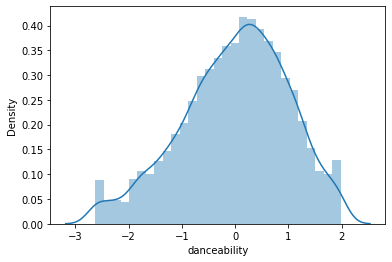

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


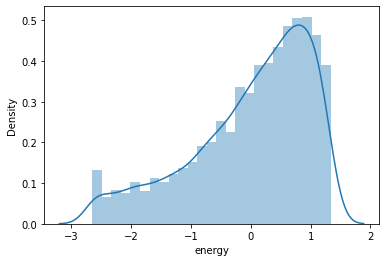

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


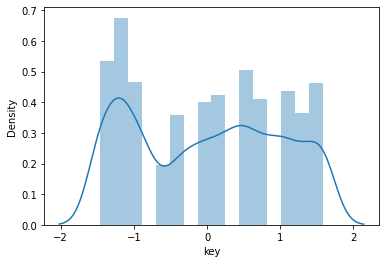

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


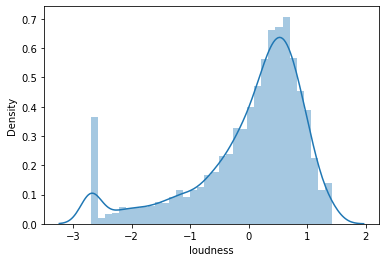

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


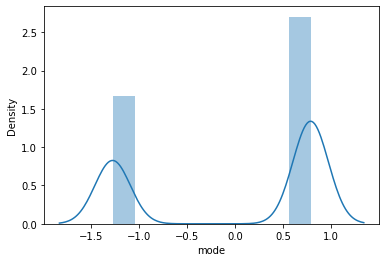

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


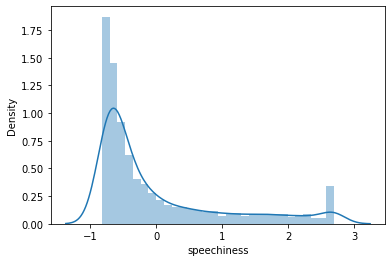

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


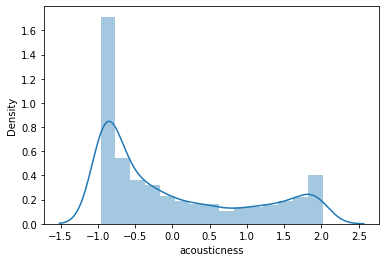

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


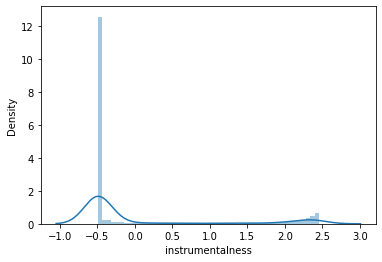

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


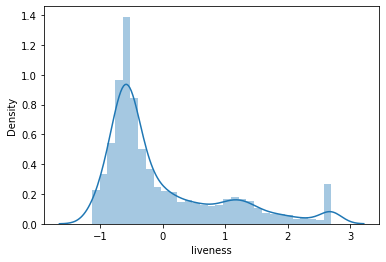

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


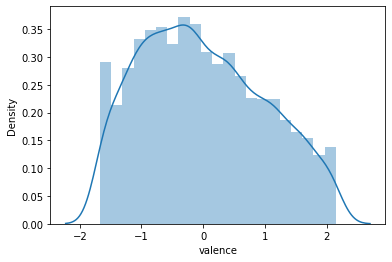

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


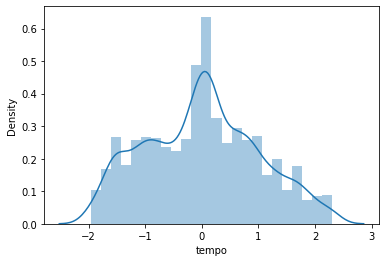

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


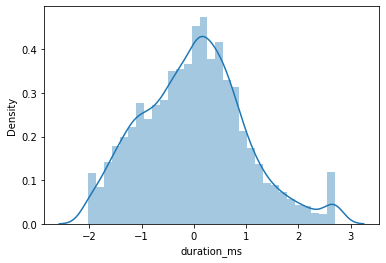

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


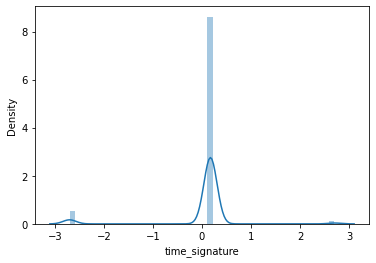

In [142]:
#plot the distribution of the features
for i in rawfeaturesDF.columns:
    sns.distplot(rawfeaturesDF[i])
    plt.show()

In [143]:
# apply log transformation to the features
logfeaturesDF = rawfeaturesDF.copy(deep=True)

columns_to_log=['liveness', 'instrumentalness', 'acousticness', 'speechiness','loudness','energy']

for i in columns_to_log:
    logfeaturesDF[i] = np.log(logfeaturesDF[i] + 1)

c:\Users\mlar5\anaconda3\envs\TextMining\lib\site-packages\pandas\core\arraylike.py:405: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
